In [9]:
import pandas as pd
import numpy as np

# Benchmark Generation

In [10]:
from aeon.datasets import load_classification

In [11]:
# Number time series per benchmark
NB_SERIES  = 250
# Percentage train
TRAIN_SIZE = 0.20

In [12]:
def get_kappa_max(nclasses):
    return int(np.floor((nclasses+1)/3))

def znormalize(series):
    series = (series - np.mean(series, axis=None)) / np.std(series, axis=None)
    return series

In [ ]:
import benchmark_generation 

# Datasets used in the LoCoMotif paper:
VAR_LENGTH_DATASETS = ["CharacterTrajectories", "SpokenArabicDigits", "JapaneseVowels"]
FIX_LENGTH_DATASETS = ["ArticularyWordRecognition", "ERing", "Plane", "Cricket", "Mallat", "UWaveGestureLibrary", "Symbols", "PenDigits", "Fungi", "NATOPS", "ECG5000"]
DATASETS = VAR_LENGTH_DATASETS + FIX_LENGTH_DATASETS

dataset_name = "CharacterTrajectories"

In [4]:
X_train, y_train = load_classification(name=dataset_name, split='train', load_equal_length=False)
X_test,  y_test  = load_classification(name=dataset_name, split='test', load_equal_length=False)


df_train, df_test = pd.DataFrame({'series': [x.T for x in X_train], 'label': y_train}), pd.DataFrame({'series': [x.T for x in X_test], 'label': y_test}) 
df = pd.concat((df_train, df_test), axis=0).reset_index(drop=True)
df['length'] = df['series'].apply(len)

print(df['length'].min())
print(df['length'].max())

df['series'] = df['series'].apply(znormalize)

np.random.seed(0)
# Resplit
df_train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=TRAIN_SIZE)).sample(frac=1.0).reset_index(drop=True)
df_test  = df.drop(df_train.index).sample(frac=1.0).reset_index(drop=True)

# Generate
classes = df['label'].unique()
nclasses  = len(classes)

if nclasses <= 5:
    raise ValueError("Number of classes should be above 5.")
    
kappa_max = get_kappa_max(nclasses)
    
nb_train = int(TRAIN_SIZE * NB_SERIES) 
nb_test  = NB_SERIES - nb_train
    
benchmark_train = benchmark_generation.generate_tsmd_benchmark(df_train, nb_train, kappa_min=2, kappa_max=kappa_max)
benchmark_test  = benchmark_generation.generate_tsmd_benchmark(df_test,  nb_test,  kappa_min=2, kappa_max=kappa_max)

60
182


In [5]:
import matplotlib.pyplot as plt

def plot_motif_sets(series, motif_sets, gt=None, dimension_names=None, legend=True):
    if series.ndim == 1:
        series = np.expand_dims(series, axis=1)
    if dimension_names is None:
        dimension_names = [f"dim {d+1}" for d in range(series.shape[1])]

    n = len(series)
    fig, axs = plt.subplots(len(motif_sets) + 1, 1, figsize=(12, (len(motif_sets) + 1) * 1.5), sharex=True, sharey=True)

    if np.array(axs).ndim == 0:
        axs = [axs]

    axs[0].plot(range(len(series)), series, lw=1.5)
    if legend:
        axs[0].legend(dimension_names, fontsize=10)
    axs[0].set_xlim((0, n))

    if gt is not None:
        plot_ground_truth_ax(axs[0], gt, n)

    for i, motif_set in enumerate(motif_sets):
        axs[i+1].set_title(f"Motif Set {i+1}, k: {len(motif_set)}", fontsize=14)
        for s_m, e_m in motif_set:
            axs[i+1].set_prop_cycle(None)
            axs[i+1].plot(range(s_m, e_m), series[s_m : e_m, :], alpha=1, lw=1.5)
            axs[i+1].axvline(x=s_m, c='k', linestyle=':', lw=0.25)
            axs[i+1].axvline(x=e_m, c='k', linestyle=':', lw=0.25)

    plt.tight_layout()
    return fig, axs

def plot_ground_truth_ax(ax, gt, n):
    for key in gt.keys():
        for (s, e) in gt[key]:
            ax.axvline(x=s, c='k', linestyle=':', lw=0.25)
            ax.axvline(x=e, c='k', linestyle=':', lw=0.25)
            
            text_x = (s + ((e - s) // 2)) / float(n)
            text_y = 0.90
            ax.text(text_x, text_y, str(key), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
    plt.tight_layout()
    return ax

# Evaluation

(<Figure size 1200x150 with 1 Axes>, [<Axes: >])

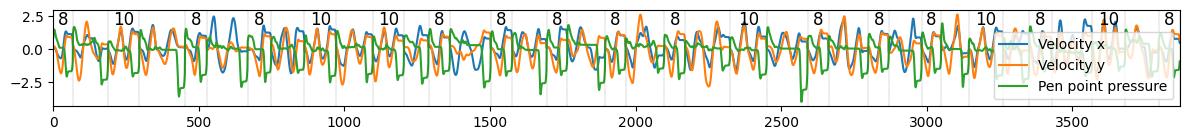

In [6]:
series, gt, *_ = benchmark_train.iloc[4]
plot_motif_sets(series, [], gt=gt, dimension_names=['Velocity x', 'Velocity y', 'Pen point pressure'])

(<Figure size 1200x900 with 6 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Motif Set 1, k: 16'}>,
        <Axes: title={'center': 'Motif Set 2, k: 11'}>,
        <Axes: title={'center': 'Motif Set 3, k: 7'}>,
        <Axes: title={'center': 'Motif Set 4, k: 5'}>,
        <Axes: title={'center': 'Motif Set 5, k: 5'}>], dtype=object))

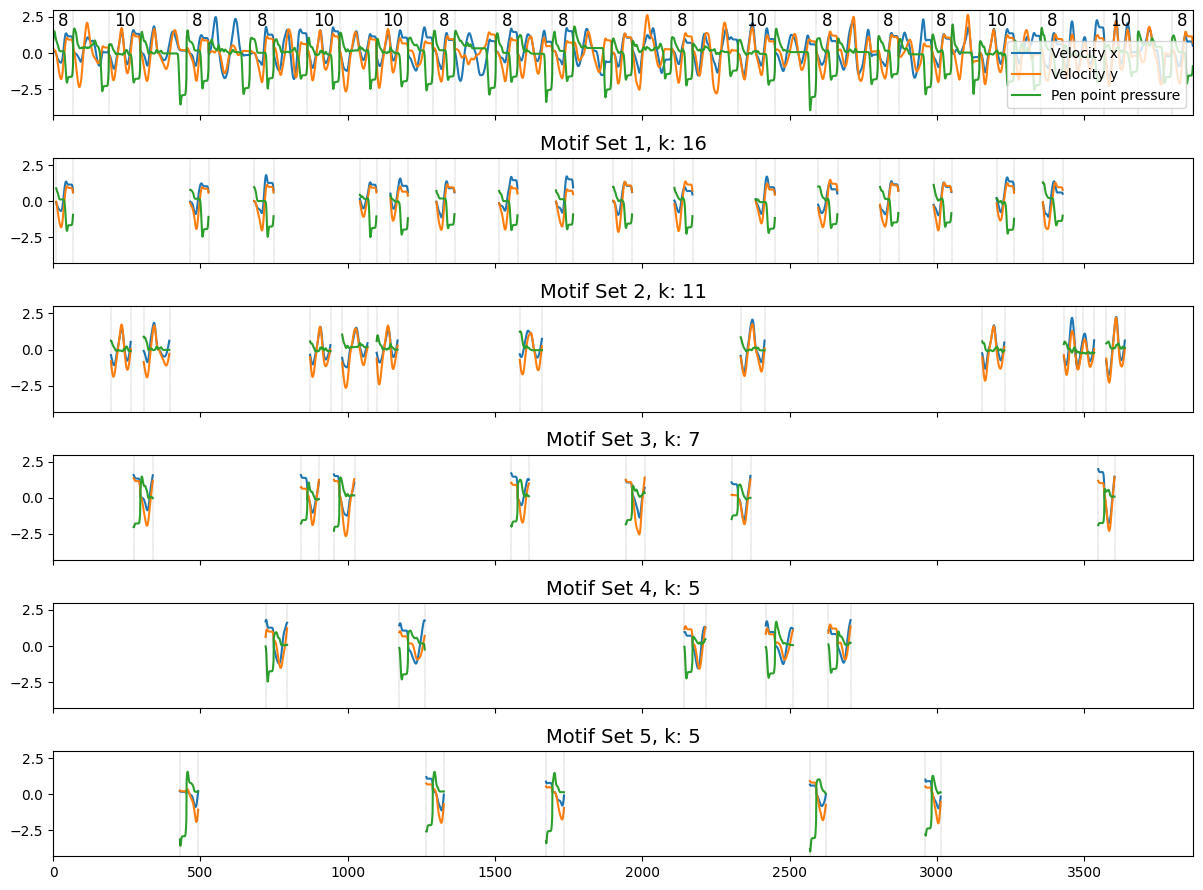

In [7]:
# import locomotif.locomotif as locomotif
# motif_sets = locomotif.apply_locomotif(series, rho=0.9, l_min=60, l_max=182, nb=5)

motif_sets = [
    [(465, 528), (682, 749), (1514, 1577), (10, 68), (2109, 2171), (1301, 1363), (1901, 1966), (1707, 1766), (2597, 2663), (2385, 2451), (2989, 3050), (3203, 3263), (1145, 1205), (2807, 2870), (1041, 1098), (3360, 3428)], 
    [(872, 942), (2334, 2416), (196, 264), (3154, 3230), (981, 1068), (1098, 1170), (307, 395), (3431, 3495), (3471, 3535), (1584, 1660), (3575, 3639)], 
    [(841, 903), (2303, 2368), (953, 1023), (273, 339), (1944, 2009), (1555, 1616), (3548, 3604)], [(721, 795), (1175, 1262), (2632, 2708), (2143, 2215), (2419, 2512)], 
    [(1673, 1735), (2569, 2624), (1267, 1327), (430, 493), (2961, 3014)]
]

plot_motif_sets(series, motif_sets, gt=gt, dimension_names=['Velocity x', 'Velocity y', 'Pen point pressure'])

In [8]:
import evaluation as evaluation

mm, row_names, col_names = evaluation.match_matrix(gt, motif_sets)

# evaluation.pretty_print_match_matrix(mm, row_names, col_names)
print(mm)

print(evaluation.precision(mm))
print(evaluation.recall(mm))
print(evaluation.f1_score(mm))

[[ 6  0  0  0  0  0]
 [ 0 12  0  0  0  1]
 [ 5  4  7  5  5  0]]
0.6666666666666666
0.9473684210526315
0.782608695652174
